# Bài toán

Trong notebook này, chúng ta sẽ ứng dụng thuật toán hồi quy tuyến tính mà chúng ta đã học trong khóa học này.

Hãy đọc dữ liệu bằng thư viện Pandas, sau đó sử dụng thuật toán hồi quy tuyến tính với các đặc trưng khác nhau nhằm tìm ra thuật toán hồi quy tuyến tính tốt nhất thông qua phương pháp đánh giá độ chính xác.

Tập dữ liệu và bài toán thuộc dạng hồi quy cổ điển. Với một số đặc trưng nhất định, chúng ta cần xây dựng một mô hình hồi quy tuyến tính để xác định **số lượng hồ sơ được chấp nhận** dựa vào các đặc trưng đã có.

Để giải quyết bài toán này, chúng ta cần phân tích dữ liệu, thực hiện bất kỳ chuyển đổi và chuẩn hóa cần thiết nào, áp dụng thuật toán ML, huấn luyện mô hình, kiểm tra chất lượng của mô hình đã huấn luyện và lặp lại cho đến khi có được chất lượng cao nhất cho tập dữ liệu của mình.

# Pipeline

1. Đọc dữ liệu.

2. Tiền xử lý dữ liệu.

3. Trực quan dữ liệu.

4. Chuẩn bị dữ liệu.

5. Xây dựng mô hình hồi quy tuyến tính đơn biến.

6. Xây dựng mô hình hồi quy tuyến tính đa biến.

7. Xây dựng mô hình hồi quy tuyến tính trên toàn bộ đặc trưng để quan sát mối quan hệ giữa các đặc trưng và mục tiêu.

8. Xây dựng mô hình Lasso để lựa chọn đặc trưng tốt nhất cho mục tiêu.

# Tập dữ liệu

Dự án này liên quan đến tập dữ liệu College, trong file [College.csv](https://drive.google.com/file/d/167ysw5-Bf15_Gm_aiePZfrS3fBWWfJVl/view) trong thư mục dữ liệu. Nó chứa các biến sau cho 777 trường đại học và cao đẳng khác nhau ở Mỹ:

**Private**: Chỉ báo public/private

**Apps**: Số lượng hồ sơ nhận được

**Accept**: Số lượng sinh viên được chấp thuận

**Enroll**: Số sinh viên mới đăng ký

**Top10perc**: Sinh viên mới từ top 10% lớp trung học

**Top25perc**: Sinh viên mới từ top 25% lớp trung học

**F.Undergrad**: Số sinh viên đại học toàn thời gian

**P.Undergrad**: Số sinh viên đại học bán thời gian

**Outstate**: Học phí ngoại bang

**Room.Board**: Chi phí ăn ở

**Books**: Chi phí giáo trình theo ước tính

**Personal**: Chi tiêu cá nhân theo ước tính

**PhD**: Phần trăm giảng viên có bằng Tiến sĩ

**Terminal**: Phần trăm giảng viên có Terminal degree (bẳng cấp cao nhất trong một lĩnh vực nhất định)

**S.F.Ratio**: Tỷ lệ sinh viên/giảng viên

**perc.alumni**: Phần trăm cựu sinh viên đã quyên góp

**Expend**: Chi phí giảng dạy cho mỗi sinh viên

**Grad.Rate**: Tỷ lệ tốt nghiệp

# Thư viện cần thiết

In [61]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

plt.style.use('ggplot')

# Hàm tiện ích

Phương pháp tiện ích này sẽ giúp vẽ biểu đồ các quan sát thử nghiệm của bạn, so sánh chúng với đường hồi quy và hiển thị hệ số R2.

In [62]:
def drawLine(model, X_test, y_test, title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 1 đặc trưng
    # và hiển thị hệ số R2
    y_pred = model.predict(X_test)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_test, y_test, c='g', marker='o')
    ax.plot(X_test, y_pred, color='orange', linewidth=1, alpha=0.7)
    ax.set_xlabel(title)
    ax.set_ylabel('Accept')

    R2 = r2_score(y_test, y_pred)

    ax.set_title(title)
    print("R2: " + str(R2))
    print("Intercept(s): ", model.intercept_)

    plt.show()

In [63]:
def drawPlane(model, X_test, y_test, title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 2 đặc trưng
    # và hiển thị hệ số R2
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_zlabel('prediction')


    # Chuyển về numpy vì X_test có thể là DataFrame, v.v.
    X_test = np.array(X_test)
    col1 = X_test[:,0]
    col2 = X_test[:,1]


    # Lấy giá trị nhỏ nhất và lớn nhất của 2 đặc trưng
    # để vẽ siêu mặt phẳng
    # do điểm nhỏ nhất và lớn nhất sẽ bao bọc toàn bộ dữ liệu
    x_min, x_max = col1.min(), col1.max()
    y_min, y_max = col2.min(), col2.max()
    x = np.arange(x_min, x_max, (x_max-x_min) / 10)
    y = np.arange(y_min, y_max, (y_max-y_min) / 10)
    x, y = np.meshgrid(x, y)


    # Dự đoán để lấy siêu mặt phẳng
    z = model.predict(np.c_[x.ravel(), y.ravel()])
    z = z.reshape(x.shape)

    # Trực quan hóa dữ liệu và vẽ siêu mặt phẳng
    ax.scatter(col1, col2, y_test, c='g', marker='o')
    ax.plot_wireframe(x, y, z, color='orange', alpha=0.7)

    y_pred = model.predict(X_test)
    R2 = r2_score(y_test, y_pred)

    ax.set_title(title)
    print("R2: " + str(R2))
    print("Intercept(s): ", model.intercept_)

    plt.show()

# Task 1: Đọc dữ liệu từ tập dữ liệu College

Chỉ mục là cột tên trường đại học.

In [64]:
# Nhập code của bạn ở đây

# Đọc dữ liệu từ file CSV và đặt cột đầu tiên làm index
df = pd.read_csv('College.csv', index_col=0)
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 2: Mã hóa hạng mục

Sử dụng map() để chuyển đổi cột Private thành {'Yes':1, 'No':0}.

Hầu hết tất cả thuật toán học máy đều không làm việc với dữ liệu chuỗi hoặc hạng mục, do đó cần chuyển đổi những loại dữ liệu này để phù hợp với đầu vào của học máy. Phương thức `.map()` giống như `.apply()`, nhưng thay vì sử dụng lambda/function, bạn chỉ cần cung cấp ánh xạ key:value.

In [65]:
# Nhập code của bạn ở đây

# Chuyển đổi cột Private thành dạng số
df['Private'] = df['Private'].map({'Yes': 1, 'No': 0})
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 3: Trực quan ma trận tương quan

Tính toán ma trận trực quan từ DataFrame

In [66]:
# Nhập code của bạn ở đây

# Tính toán ma trận tương quan
corr_matrix = df.corr()

Trực quan ma trận trực quan bằng Seaborn

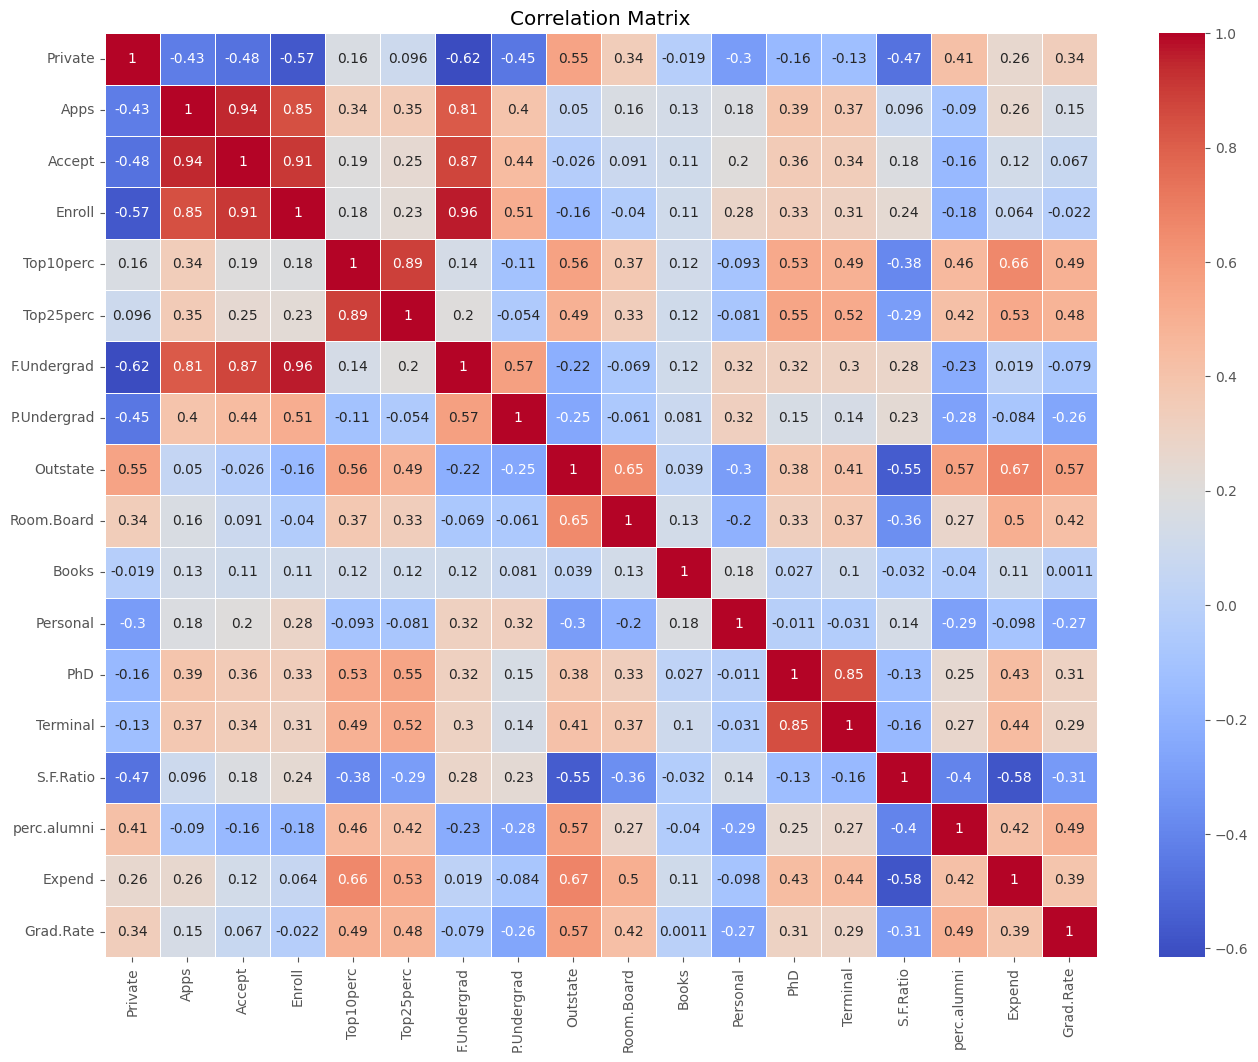

In [67]:
# Nhập code của bạn ở đây

# Trực quan hóa ma trận tương quan
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Task 4: Vẽ biểu đồ Scatter từng đặc trưng với mục tiêu

Lấy ra toàn bộ đặc trưng từ dữ liệu và loại bỏ đi mục tiêu ("Accept")

In [68]:
# Nhập code của bạn ở đây

features = df.columns.drop('Accept')

Trực quan từng đặc trưng với mục tiêu

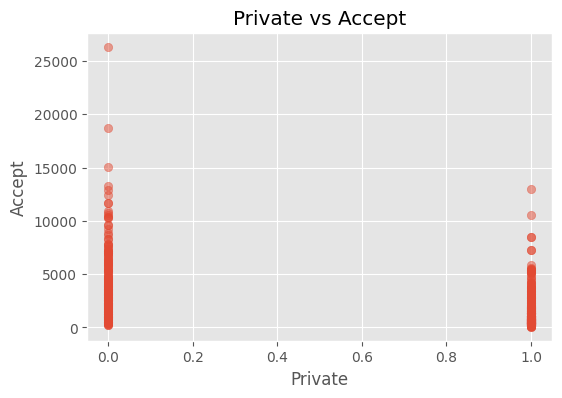

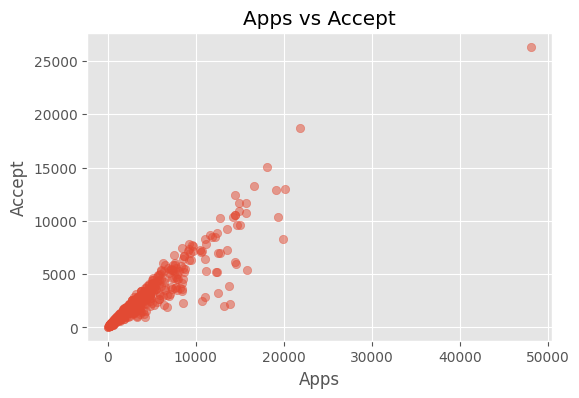

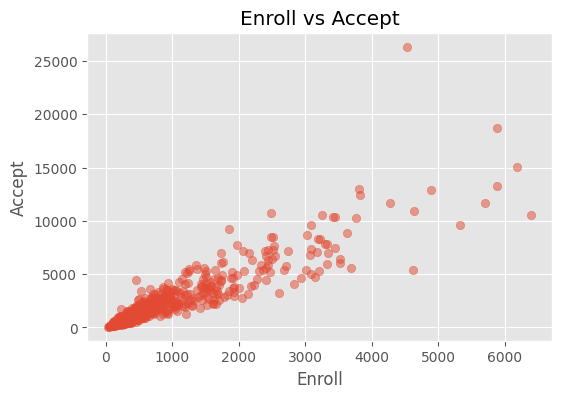

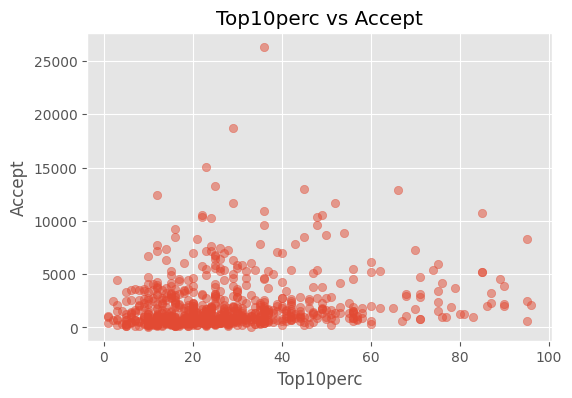

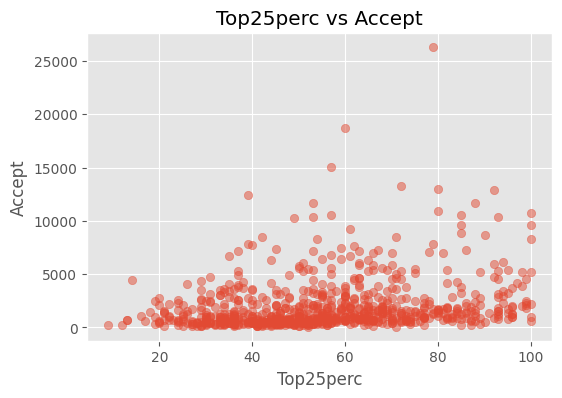

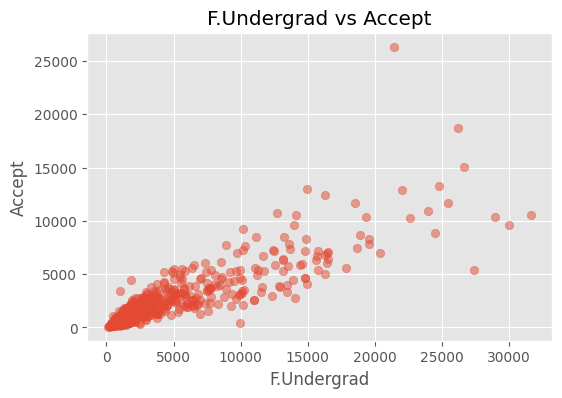

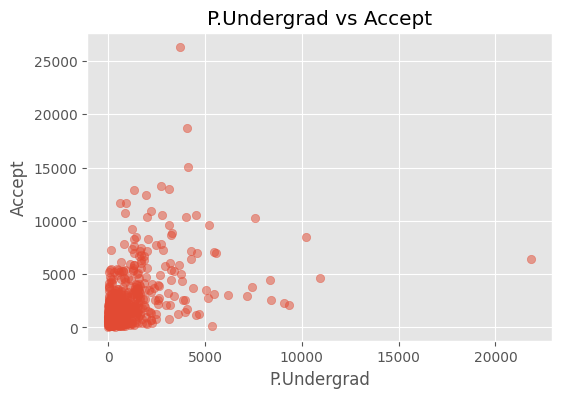

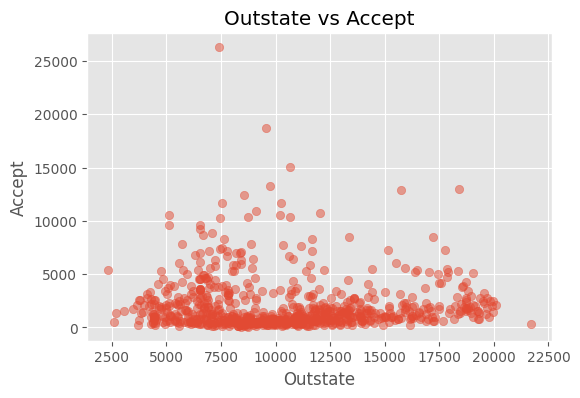

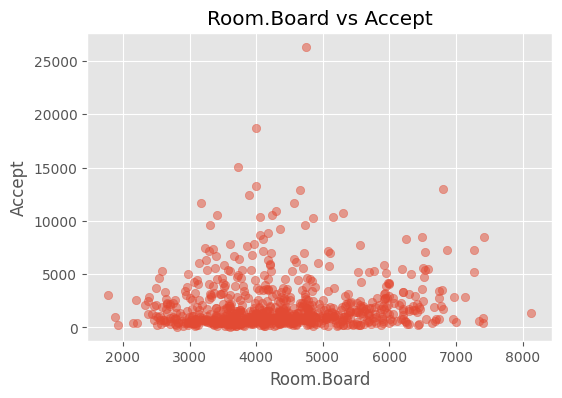

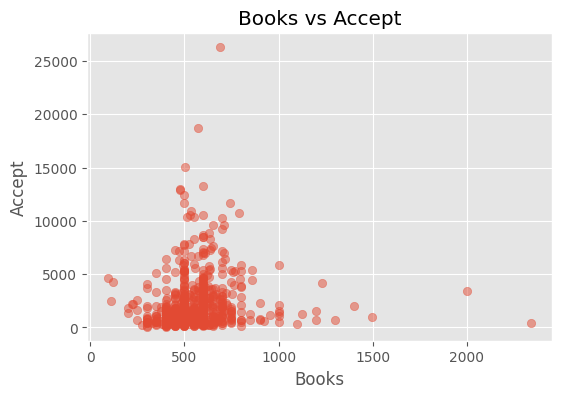

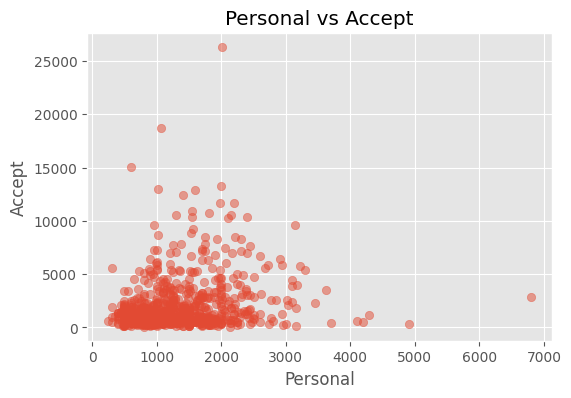

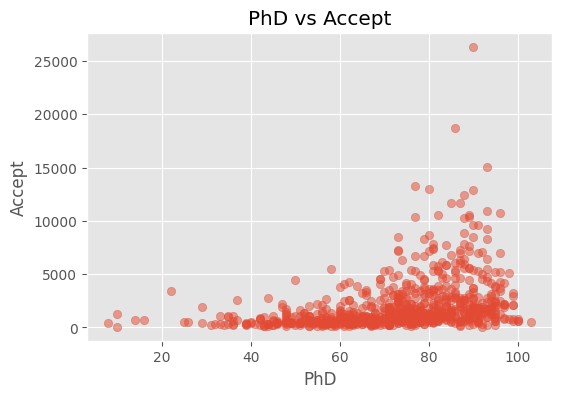

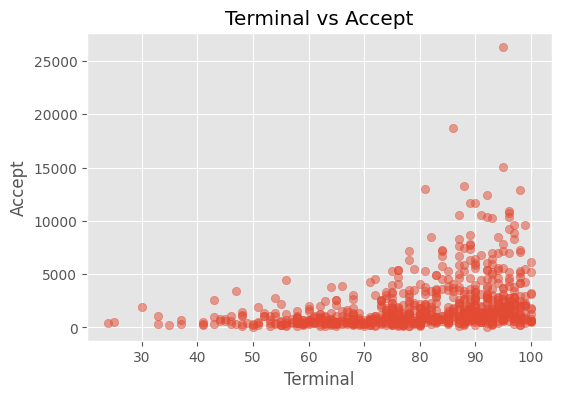

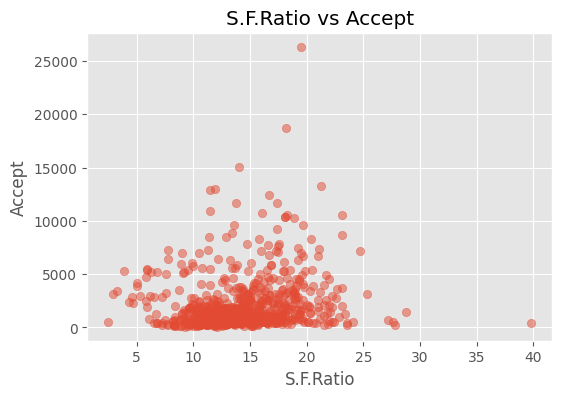

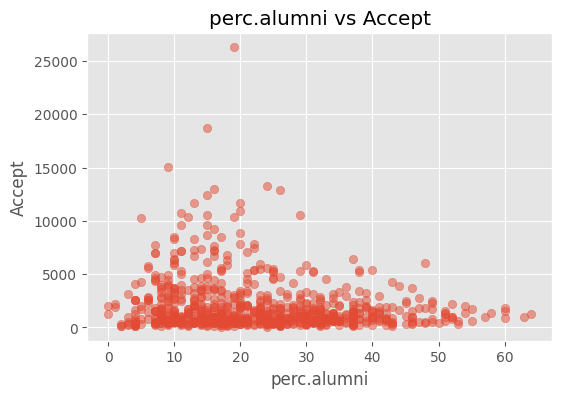

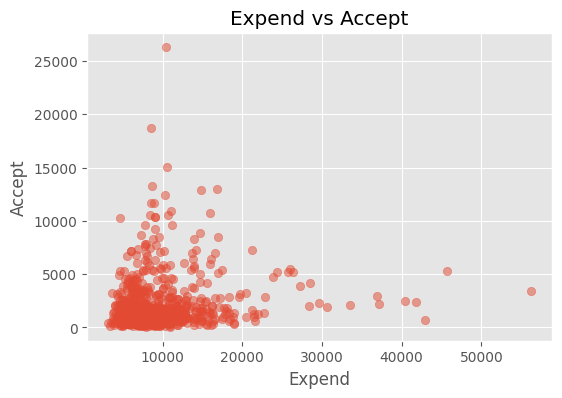

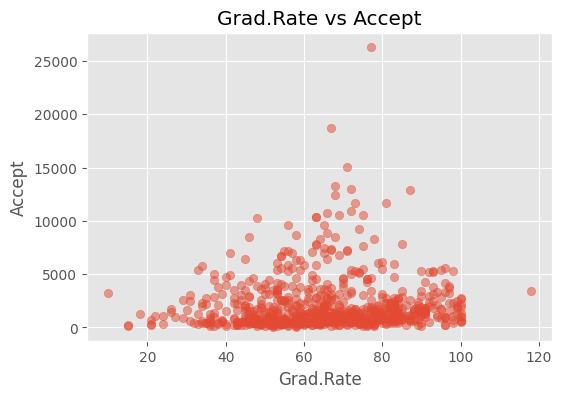

In [69]:
# Nhập code của bạn ở đây

# Vẽ biểu đồ scatter cho từng đặc trưng
for feature in features:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[feature], df['Accept'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Accept')
    plt.title(f'{feature} vs Accept')
    plt.show()

# Task 5: Phân tách dữ liệu đặc trưng vào X, dữ liệu mục tiêu vào y từ dữ liệu gốc


In [70]:
# Nhập code của bạn ở đây
X = df.drop('Accept', axis=1)
y = df['Accept']

In [71]:
X.head()

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [72]:
y.head()

Abilene Christian University    1232
Adelphi University              1924
Adrian College                  1097
Agnes Scott College              349
Alaska Pacific University        146
Name: Accept, dtype: int64

# Task 6: Tách dữ liệu thành train/test data

Dữ liệu train chiếm 70% và random_state là 7.

In [73]:
from sklearn.model_selection import train_test_split

# Nhập code của bạn ở đây
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

# Task 7: Mô hình hóa hồi quy tuyến tính chi phí ăn ở và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu chi phí ăn ở từ bộ train và test

In [74]:
# Nhập code của bạn ở đây
X_train_rb = X_train['Room.Board'].values
X_test_rb = X_test['Room.Board'].values
y_train_rb = y_train
y_test_rb = y_test

Điều chỉnh shape dữ liệu phù hợp với đầu vào của mô hình

Mô hình hồi quy tuyến tính yêu cầu đầu vào có dạng là (m, n) với X và (m, 1) với y.

Trong đó:

- m là số lượng mẫu quan sát

- n là số lượng đặc trưng

Với một đặc trưng duy nhất, shape phù hợp sẽ là (m, 1) cho X.

In [75]:
# Nhập code của bạn ở đây
X_train_rb = X_train_rb.reshape(-1, 1)
X_test_rb = X_test_rb.reshape(-1, 1)

Xây dựng và huấn luyện mô hình

In [76]:
# Nhập code của bạn ở đây
model_1 = LinearRegression()
model_1.fit(X_train_rb, y_train_rb)


LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [77]:
# Nhập code của bạn ở đây
r2_score_1 = r2_score(y_test_rb, model_1.predict(X_test_rb))
print(f"R2 Score: {r2_score_1}")

R2 Score: -0.0026669864145500988


Trực quan mô hình hóa với dữ liệu test

R2: -0.0026669864145500988
Intercept(s):  1340.619565189838


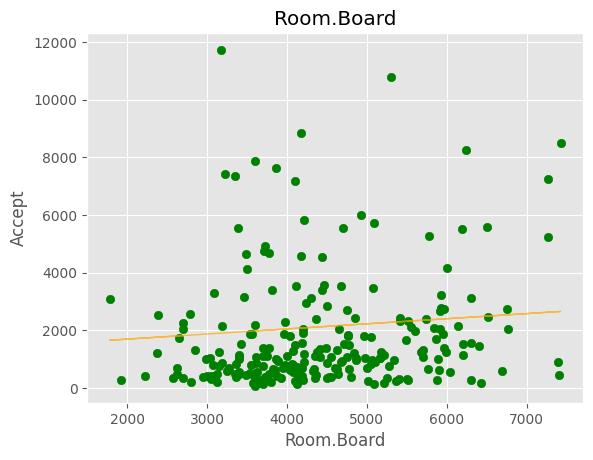

In [78]:
# Nhập code của bạn ở đây
drawLine(model_1, X_test_rb, y_test_rb, 'Room.Board')

# Task 8: Mô hình hóa hồi quy tuyến tính số lượng sinh viên ghi danh cho mỗi trường đại học và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học ở từ bộ train và test

In [79]:
# Nhập code của bạn ở đây
X_train_enroll = X_train['Enroll'].values
X_test_enroll = X_test['Enroll'].values

Điều chỉnh shape phù hợp với đầu vào của mô hình

In [80]:
# Nhập code của bạn ở đây
X_train_enroll = X_train_enroll.reshape(-1, 1)
X_test_enroll = X_test_enroll.reshape(-1, 1)

Xây dựng và huấn luyện mô hình

In [81]:
# Nhập code của bạn ở đây
model_2 = LinearRegression()
model_2.fit(X_train_enroll, y_train)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [82]:
# Nhập code của bạn ở đây
r2_score_2 = r2_score(y_test, model_2.predict(X_test_enroll))
print(f"R2 Score: {r2_score_2}")

R2 Score: 0.8578204867356156


Trực quan mô hình với dữ liệu test

R2: 0.8578204867356156
Intercept(s):  151.7261124227632


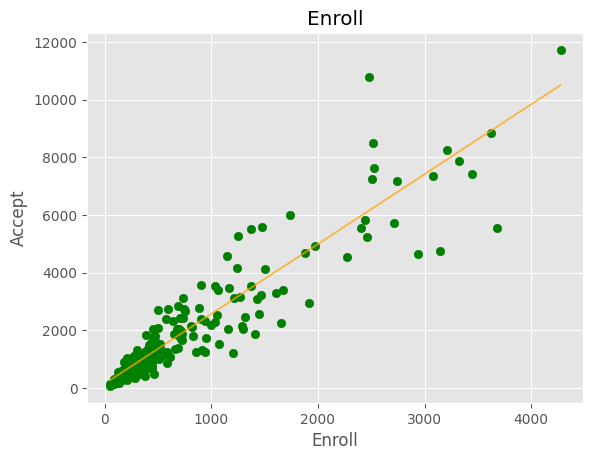

In [83]:
# Nhập code của bạn ở đây
drawLine(model_2, X_test_enroll, y_test, 'Enroll')

# Task 9: Mô hình hóa hồi quy tuyến tính từng đặc trưng với số lượng sinh viên được chấp nhận và trực quan hóa mô hình với dữ liệu test

Lưu ý: Sử dụng vòng lặp

R2: 0.22400751013309883
Intercept(s):  4082.934210526321


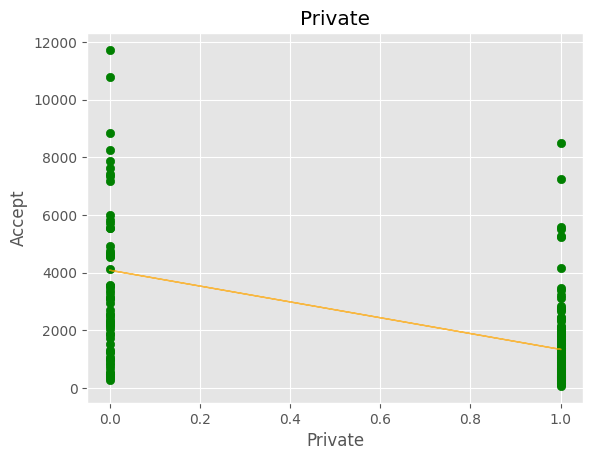

R2: 0.8278338672174984
Intercept(s):  215.66921083593638


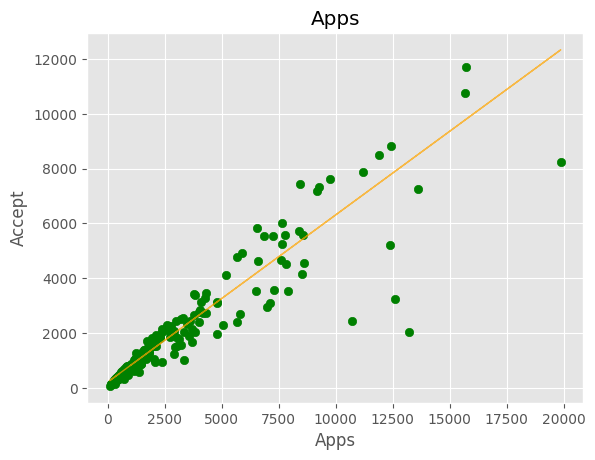

R2: 0.8578204867356156
Intercept(s):  151.7261124227632


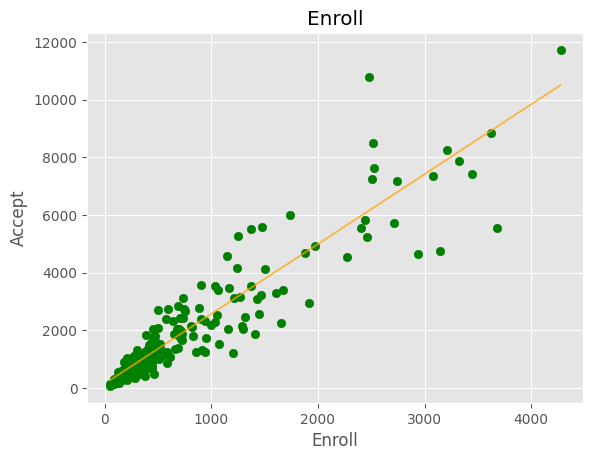

R2: 0.04653179053543455
Intercept(s):  1397.3784275961889


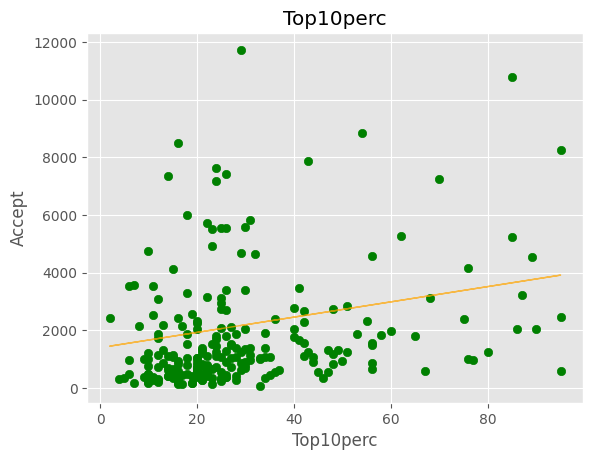

R2: 0.05631647635294568
Intercept(s):  378.8846828301889


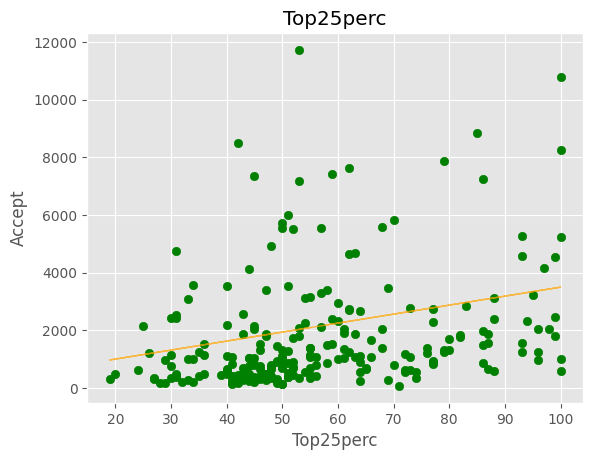

R2: 0.7779917973754006
Intercept(s):  380.94291049842764


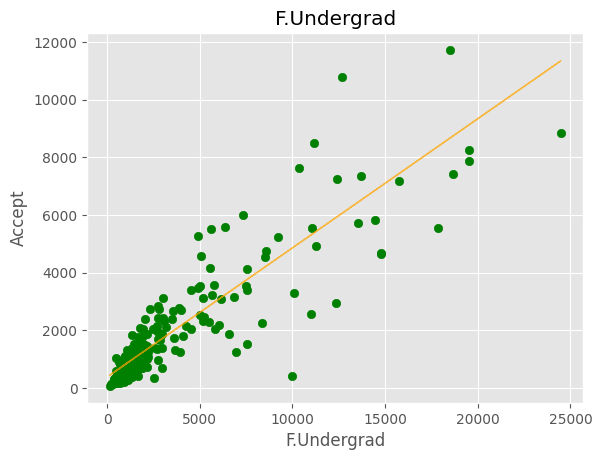

R2: 0.15365724454940088
Intercept(s):  1444.348151749116


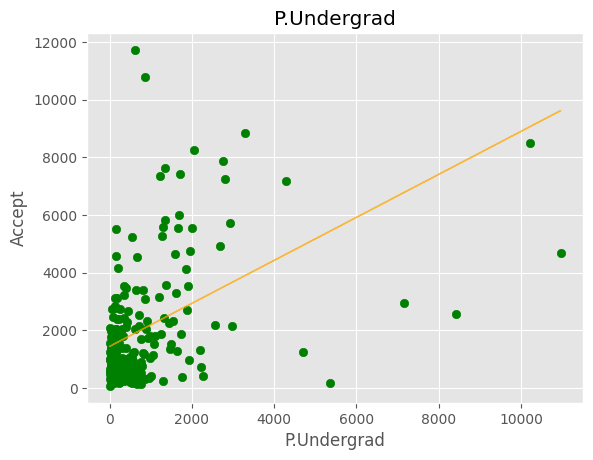

R2: -0.03441717957246171
Intercept(s):  2472.297811569735


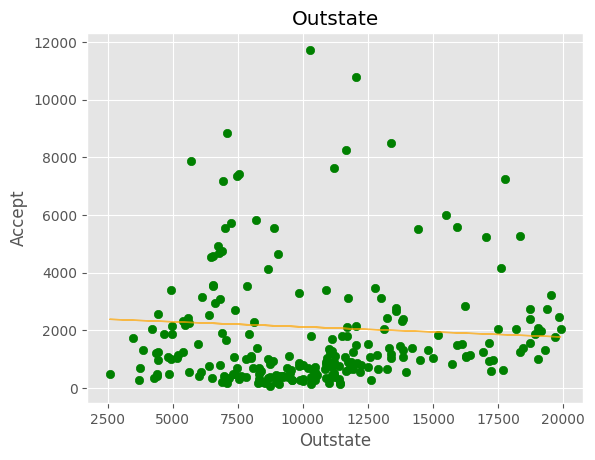

R2: -0.0026669864145500988
Intercept(s):  1340.619565189838


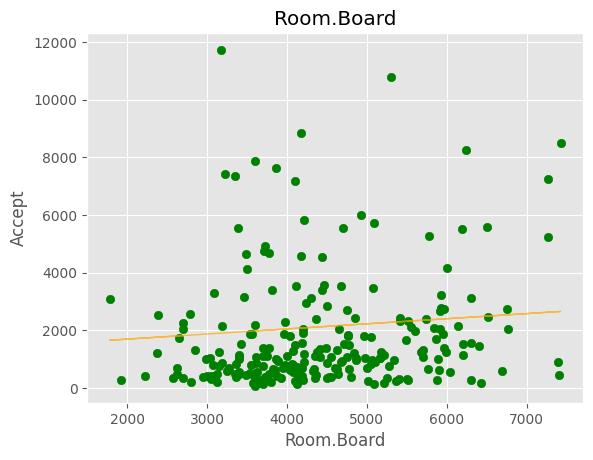

R2: 0.012015078321136241
Intercept(s):  1304.8355956198193


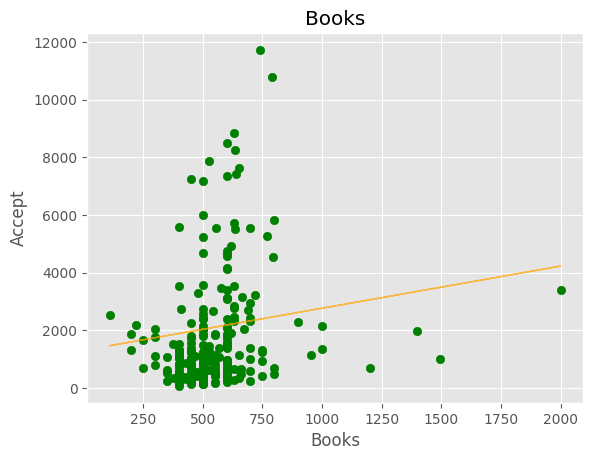

R2: 0.053082024881150325
Intercept(s):  1185.975607940944


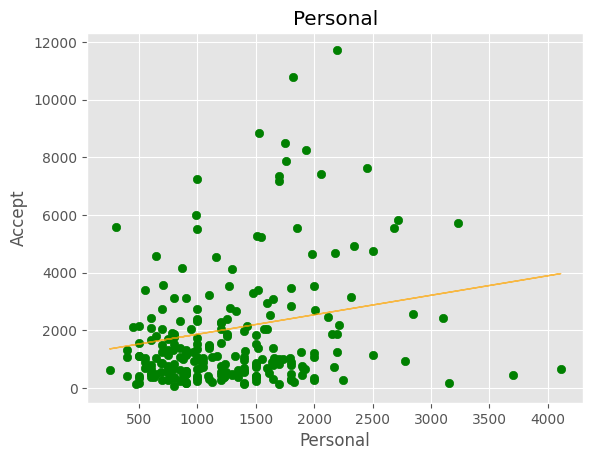

R2: 0.14442475831652213
Intercept(s):  -1901.7356825532374


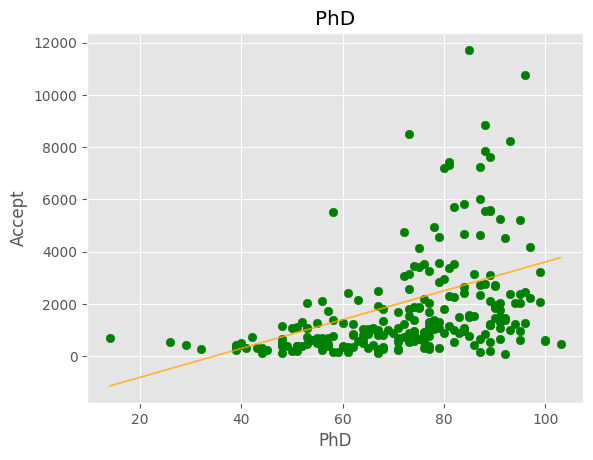

R2: 0.10721305445042717
Intercept(s):  -2566.341123006579


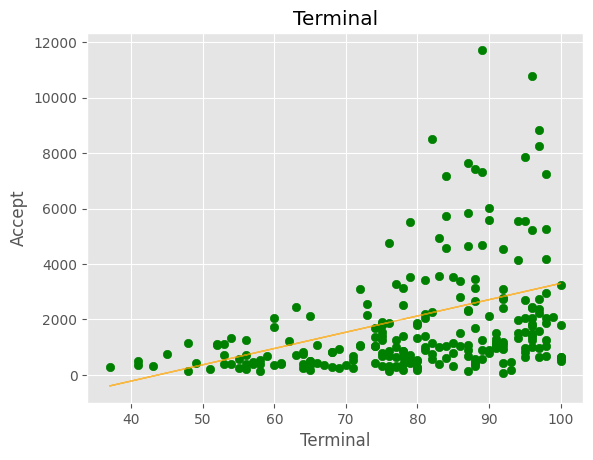

R2: -0.0012154874950456307
Intercept(s):  406.0892030188854


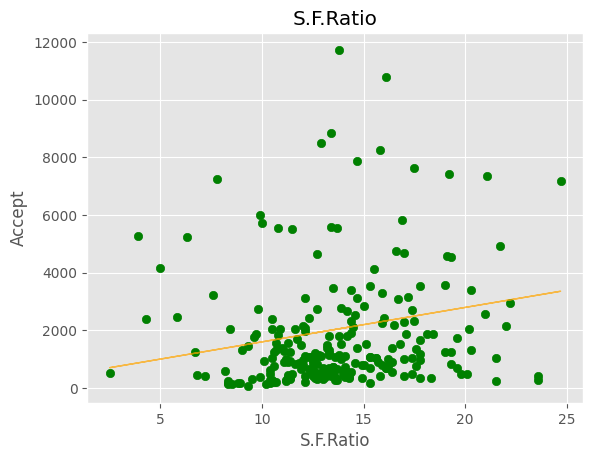

R2: 0.006075121043538134
Intercept(s):  2869.319570792186


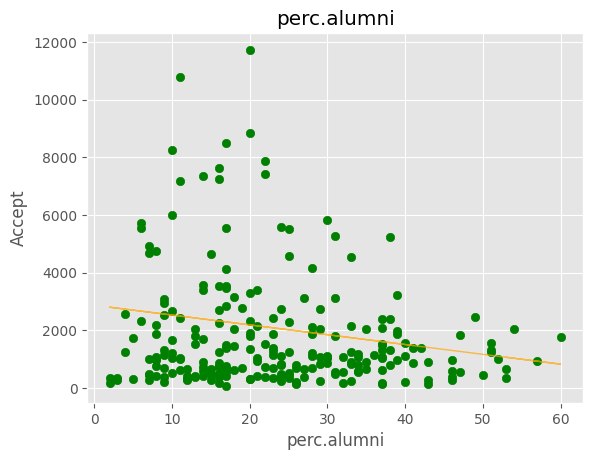

R2: 0.019419509650065114
Intercept(s):  1652.5167772242703


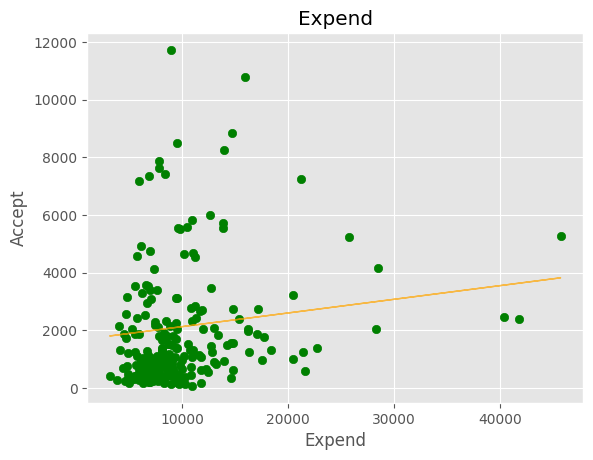

R2: -0.018954776268819362
Intercept(s):  1407.4974601852537


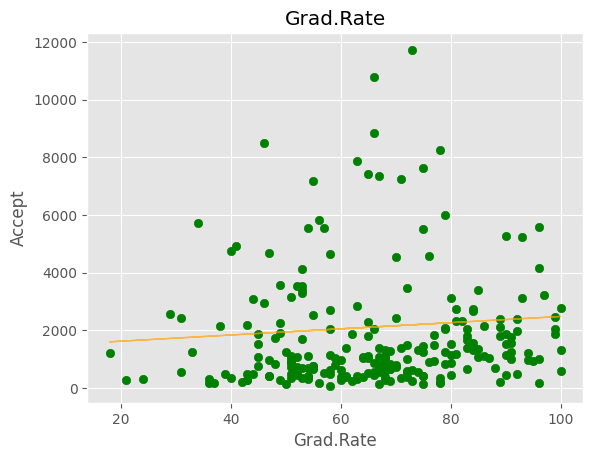

In [84]:
# Nhập code của bạn ở đây
for feature in X.columns:
    X_train_feature = X_train[feature].values.reshape(-1, 1)
    X_test_feature = X_test[feature].values.reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(X_train_feature, y_train)
    
    drawLine(model, X_test_feature, y_test, feature)

# Task 10: Mô hình hóa hồi quy tuyến đa biến số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở để dự đoán số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở từ bộ train và test

In [85]:
# Nhập code của bạn ở đây
X_train_multi = X_train[['Enroll', 'Room.Board']]
X_test_multi = X_test[['Enroll', 'Room.Board']]

Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý dữ liệu của chúng ta ở phần này là 2 đặc trưng, do đó đầu vào của mô hình đối với X sẽ là (m, 2)

In [86]:
# Nhập code của bạn ở đây
print("Shape of X_train_multi:", X_train_multi.shape)
print("Shape of X_test_multi:", X_test_multi.shape)

Shape of X_train_multi: (543, 2)
Shape of X_test_multi: (234, 2)


Xây dựng và huấn luyện mô hình

In [87]:
# Nhập code của bạn ở đây
model_multi = LinearRegression()
model_multi.fit(X_train_multi, y_train)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [88]:
# Nhập code của bạn ở đây
r2_score_multi = r2_score(y_test, model_multi.predict(X_test_multi))
print(f"R2 Score: {r2_score_multi}")

R2 Score: 0.8764371774214047


Trực quan mô hình với dữ liệu test

In [89]:
# Nhập code của bạn ở đây
drawPlane(model_multi, X_test_multi, y_test, 'Enroll and Room.Board')

R2: 0.8764371774214047
Intercept(s):  -1176.6284824940835


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<Figure size 640x480 with 0 Axes>

# Task 11: Sử dụng hồi quy tuyến tính với toàn bộ đặc trưng để quan sát tác động của từng đặc trưng đến mục tiêu

Tạo một bản sao về dữ liệu train và test

In [90]:
# Nhập code của bạn ở đây

Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý rằng đầu vào của mô hình lúc này sẽ là (m, n).

In [91]:
# Nhập code của bạn ở đây


Trong hồi quy tuyến tính, đặc trưng có miền giá trị lớn hơn sẽ chiếm ưu thế hơn so với đặc trưng có miền giá trị nhỏ hơn. Để công bằng cho tất cả dặc trưng chúng ta sẽ áp dụng một phương pháp được gọi là co dãn đặc trưng

In [92]:
from sklearn.preprocessing import StandardScaler

# Nhập code của bạn ở đây
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Xây dựng và huấn luyện mô hình

In [93]:
# Nhập code của bạn ở đây
model_full = LinearRegression()
model_full.fit(X_train_scaled, y_train)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [94]:
# Nhập code của bạn ở đây
r2_score_full = r2_score(y_test, model_full.predict(X_test_scaled))
print(f"R2 Score: {r2_score_full}")

R2 Score: 0.9196285274563069


Quan sát trong số đối với từng đặc trưng để kiểm tra xem đặc trưng nào có tác động mạnh hơn tới số lượng sinh viên được chấp nhận.

Đối chiếu trọng số của từng đặc trưng với ma trận trực quan để đối chiếu kết quả, nếu giá trị trong ma trận tương quan là dương lớn thì tham số đối với đặc trưng đó sẽ lớn và ngược lại.

Để hoàn thành được phần này, bạn hãy tham khảo và tìm ra cách lấy trọng số cho các đặc trưng từ [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) của Sklearn

In [95]:
# Nhập code của bạn ở đây
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': abs(model_full.coef_)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

        feature   importance
1          Apps  1788.195579
2        Enroll  1166.094588
3     Top10perc   497.683550
7      Outstate   271.437135
15       Expend   160.924662
5   F.Undergrad   153.254558
4     Top25perc   152.959466
0       Private    86.338167
11          PhD    86.299723
14  perc.alumni    62.339947
6   P.Undergrad    57.395226
13    S.F.Ratio    36.078715
16    Grad.Rate    26.608065
10     Personal    19.553777
12     Terminal    16.690016
8    Room.Board    12.106168
9         Books     4.996008


**Câu hỏi: Đặc trưng nào có tác động mạnh nhất đến số lượng sinh viên được chấp nhận ?**

*Trả lời (nhấn vào đây để trả lời)*: Dựa vào kết quả của feature_importance, đặc trưng có giá trị tuyệt đối của hệ số cao nhất sẽ có tác động mạnh nhất. Ở đây giá trị đó là 'Apps' (số lượng đơn đăng ký).

**Câu hỏi: Đặc trưng nào có tác động ít nhất đến số lượng sinh viên được chấp nhận ?**

*Trả lời (nhấn vào đây để trả lời)*: Đặc trưng có giá trị tuyệt đối của hệ số thấp nhất trong feature_importance sẽ có tác động ít nhất. Ở đây giá trị đó là 'Books' (chi phí sách).

# Task 12: Xây dựng mô hình hồi quy tuyến tính của riêng bạn

Tùy ý chọn đặc trưng và điều chỉnh siêu tham số

Yêu cầu: R2 score >= 0.9


In [96]:
# Nhập code của bạn ở đây
selected_features = ['Apps', 'Enroll', 'F.Undergrad', 'Outstate', 'Room.Board']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

your_model = LinearRegression()
your_model.fit(X_train_selected, y_train)

r2_score_your_model = r2_score(y_test, your_model.predict(X_test_selected))
print(f"R2 Score: {r2_score_your_model}")

R2 Score: 0.8974674991426809


**Câu hỏi: Hãy giải thích quá trình lý do lựa chọn đặc trưng, các tham số điều chỉnh để đạt được R2 score >= 0.9**

*Trả lời (nhấn vào đây để trả lời)*: Các đặc trưng được chọn ('Apps', 'Enroll', 'F.Undergrad', 'Outstate', 'Room.Board') có khả năng liên quan chặt chẽ đến số lượng sinh viên được chấp nhận. 'Apps' và 'Enroll' trực tiếp liên quan đến quy mô tuyển sinh, 'F.Undergrad' phản ánh quy mô trường, 'Outstate' và 'Room.Board' liên quan đến chi phí học tập. Các đặc trưng này được chọn dựa trên hiểu biết về quá trình tuyển sinh và kết quả từ phân tích tương quan trước đó. Không cần điều chỉnh tham số vì LinearRegression không có hyperparameters để tinh chỉnh.

# Task 13: Sử dụng hồi quy Lasso để chọn ra đặc trưng tốt nhất để dự đoán số lượng sinh viên được chấp nhận.

Hồi quy Lasso là hồi quy tuyến tính đặc biệt được tinh chỉnh để có thể đưa các tham số của các đặc trưng không quan trọng tiến về 0 và còn lại các đặc trưng quan trọng.

Alpha càng lớn, tham số của các đặc trưng không quan trọng càng nhỏ và tiến về 0 nhanh.

Yêu cầu: Tìm giá trị alpha sao cho mô hình đạt R2 score >= 0.92

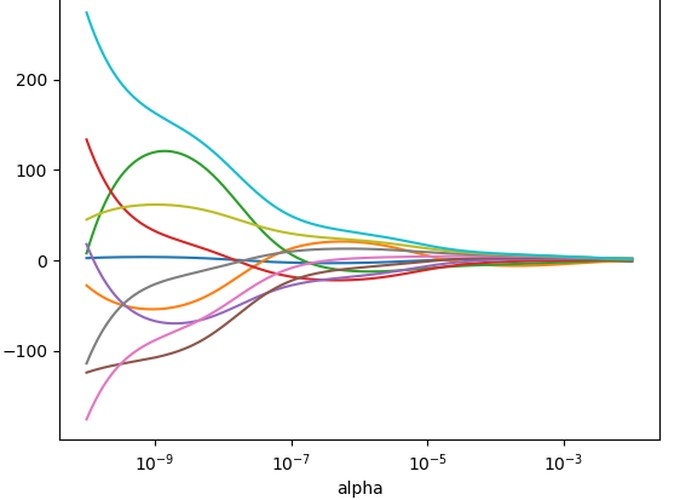

In [97]:
from sklearn.linear_model import Lasso

# Nhập code của bạn ở đây
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso_model = Lasso(alpha=0.1, random_state=42)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.1, random_state=42)

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [98]:
# Nhập code của bạn ở đây
r2_score_lasso = r2_score(y_test, lasso_model.predict(X_test_scaled))
print(f"R2 Score: {r2_score_lasso}")

R2 Score: 0.9196742403623749


Quan sát tham số với từng đặc trưng để kiểm tra xem đặc trưng nào bị loại bỏ bằng phương pháp Lasso

In [99]:
# Nhập code của bạn ở đây
feature_importance_lasso = pd.DataFrame({'feature': X.columns, 'importance': abs(lasso_model.coef_)})
feature_importance_lasso = feature_importance_lasso.sort_values('importance', ascending=False)
print(feature_importance_lasso)

        feature   importance
1          Apps  1787.941126
2        Enroll  1162.607606
3     Top10perc   496.537099
7      Outstate   271.031167
15       Expend   160.687954
4     Top25perc   151.924942
5   F.Undergrad   149.529325
0       Private    86.223817
11          PhD    86.189614
14  perc.alumni    62.035056
6   P.Undergrad    57.363994
13    S.F.Ratio    35.883839
16    Grad.Rate    26.287888
10     Personal    19.571185
12     Terminal    16.467205
8    Room.Board    11.800178
9         Books     4.927283


**Câu hỏi: Đặc trưng nào bị loại bỏ trong hồi quy Lasso ?**

*Trả lời (nhấn vào đây để trả lời)*: Các đặc trưng có hệ số (coef_) bằng 0 hoặc gần 0 trong kết quả của feature_importance_lasso được coi là bị loại bỏ bởi Lasso. Ở đây không có đặc trưng nào bị loại bỏ.